In [1]:
import os
TITANIC_PATH = os.path.join('datasets', 'titanic')

In [2]:
import pandas as pd

def load_titanic_data(filename, titanic_path = TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [3]:
train_data = load_titanic_data('train.csv')
test_data = load_titanic_data('test.csv')

Let's take a peek at the top rows of the training set:

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- **Survived**: the target, 0 not survived; 1 survived.  
- **Pclass**: passenger class.  
- **Name, Sex, Age**:
- **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
- **Parch**: how many children & parents of the passenger aboard the Titanic.
- **Ticket**: ticket id
- **Fare**: price paid
- **Cabin**: passenger's cabin number
- **Embarked**: where the passenger embarked the Titanic


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


There are null values in **age, cabin and embarked**. We will ignore the Cabin. We will need to decide what to do with the null values in the age column. Replacing null values with the median age seems reasonable.   

**Name** and **ticket** will be tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Only 38% survived. The mean age was less than 30.

In [7]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [8]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [9]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

C=Cherbourg, Q=Queenstown, S=Southampton.

## 1. Preprocessing pipeline:

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
   
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names]

`DataFrameSelector` is a class to select numerical or categorical columns, since Scikit-Learn doesn't handle DataFrames yet.  

Let's build the pipeline for the numerical attributes:

**Pipeline for Numerical Attributes:**

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')

num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(['Age', 'SibSp', 'Parch', 'Fare'])),
    ('imputer', Imputer(strategy='median')),
])

In [13]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

**Pipeline for Categorical Attributes:**

We will also need an imputer for the categorical columns. The regular `Imputer` doesn't work on those:

In [14]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
   
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)
    

We can convert each categorical value to a one-hot vector using OneHotEncoder. Right now this class can only handle integer categorical/numerical inputs, but in Scikit-Learn 0.20 it will also handle string categorical inputs. So for now we import it from `future.encoders.py` ,but when Scikit-Learn 0.20 is released, you can import it from `sklearn.preprocessing` instead:

In [16]:
from future_encoders import OneHotEncoder

In [17]:
cat_pipeline = Pipeline([
    ('select_cat', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])), 
    ('imputer', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

In [18]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

**Join the numerical and categorical pipelines**

In [20]:
from sklearn.pipeline import FeatureUnion

prepocess_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline), 
])

Now we have a preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any ML model we want.

**Use the pipeline to preprocess the train data**

In [21]:
X_train = prepocess_pipeline.fit_transform(train_data)

In [22]:
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [23]:
y_train = train_data['Survived']

We are now ready to train a classifier. Let's start with Support Vector Machines:

**1. Support Vector Machines classifier (SVC):**

In [24]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Our model is trained, let's use it to make predictions on the test set:

In [25]:
X_test = prepocess_pipeline.transform(test_data)

**fit_transform vs transform:**  

When you can `.fit(X_train)`, what it does is calculate the mean and the variance from the values in `X_train`. Then calling `.transform()` will transform all of the features by subtracting the mean and dividing by the variance that is found in `fit()` function. For the convenience, these two functions can be done in one step using `.fit_transform()`.  

The reason you want to fit the scaler using only the training data is because you don't want to bias your model with information from the test data. You should only show the training data to your model in order to see the accuracy on the test set.  

If you `fit()` to your test data, you'd compute a new mean and variance for each feature. In theory these values may be very similar if your test and train sets have the same distribution, but in practice this is typically not the case.  

Instead, you want to only transform the test data by using the parameters computed on the training data (the mean and the variance).   

https://stackoverflow.com/questions/48692500/fit-transform-on-training-data-and-transform-on-test-data  

In [26]:
y_pred = svm_clf.predict(X_test)

**Cross-Validation for accuracy**

In [27]:
from sklearn.model_selection import cross_val_score

In [48]:
scores_svm = cross_val_score(svm_clf, X_train, y_train, cv=10)
scores_svm.mean()

0.7365250822835092

Over 73% accuracy is not a great score. Let's try a `RandomForestClassifier`:

**2. Random Forest Classifier:**

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [46]:
scores_forest = cross_val_score(forest_clf, X_train, y_train, cv=10)

In [47]:
scores_forest.mean()

0.8115690614005221

In [51]:
models = []
models.append(('SVM', svm_clf))
models.append(('RandomForest', forest_clf))

### Classifier Comparison:

SVM: 0.736525 
RandomForest: 0.811569 


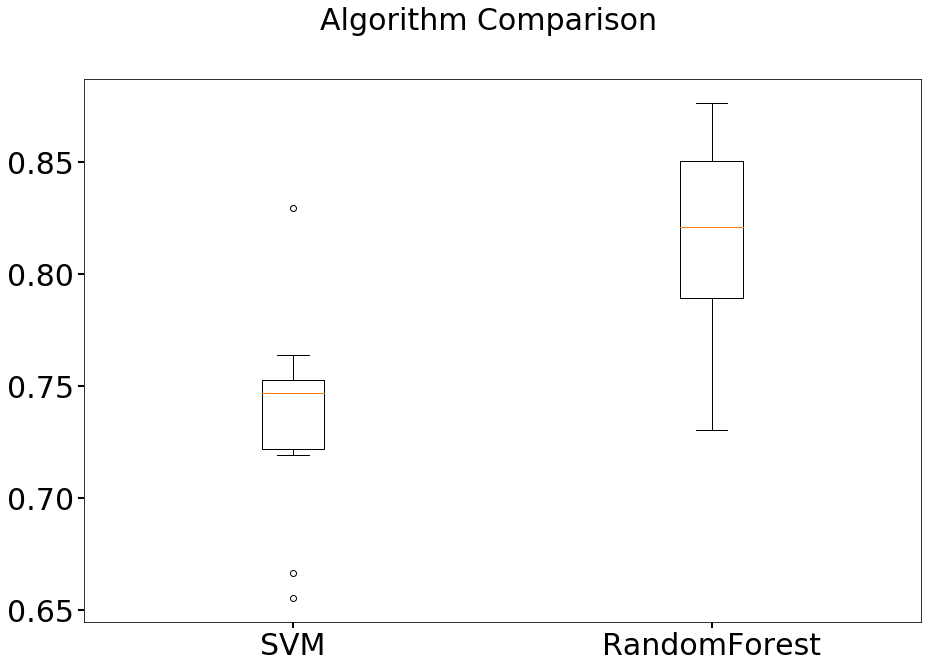

In [77]:
results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=10)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f " % (name, cv_results.mean())
    print(msg)

fig = plt.figure()
fig.set_size_inches(15, 10)
fig.suptitle('Algorithm Comparison', fontsize=30)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.tick_params(direction='out', length=6, width=2, labelsize=30)

plt.show()

# inspired by: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/